In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, \
make_scorer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
from src.functions import load_OU_data, CourseScaler
import warnings

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
pd.set_option('display.max_columns',None)

## Drop the irrelevant columns, 

In [2]:
df = load_OU_data()
df.drop(columns = ['id_student','code_presentation','region'], inplace = True)
if 'date_unregistration' in df.columns:
    df.drop(columns = ['date_unregistration'], inplace = True)
df.head()

,code_module,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,module_presentation_length,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,M,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,268,40,196,934,5,82.0
1,AAA,F,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,268,80,430,1435,5,66.4
2,AAA,F,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,268,123,663,2158,5,76.0
3,AAA,F,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,268,70,352,1034,5,54.4
4,AAA,M,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,-110.0,268,143,723,2445,5,68.0


## Preprocessing

In [3]:
X = df.drop(columns = ['final_result'])
y = df['final_result']
print(y.value_counts())
encoder = LabelEncoder()
enc_y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,enc_y, random_state=111, test_size=0.2)

Pass           11825
Fail            5607
Withdrawn       4486
Distinction     2825
Name: final_result, dtype: int64


# FSM

Cross Validation Scores:  [0.62338974 0.61353877 0.61682243 0.62642081 0.62177868]
Classification Report
accuracy 0.6261871085067691
              precision    recall  f1-score   support

 Distinction       0.48      0.10      0.16       567
        Fail       0.50      0.44      0.46      1170
        Pass       0.68      0.91      0.78      2323
   Withdrawn       0.59      0.48      0.53       889

    accuracy                           0.63      4949
   macro avg       0.56      0.48      0.48      4949
weighted avg       0.60      0.63      0.59      4949



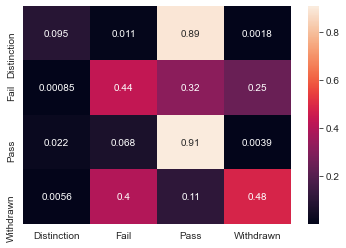

In [4]:
categoricals = X.select_dtypes(include = 'object').columns.drop('code_module')
transformers = [('ohe', OneHotEncoder(sparse=False, drop= 'first'), categoricals)]
col_transformer = ColumnTransformer(transformers = transformers, remainder='passthrough')

cv = KFold(n_splits = 5, shuffle = True, random_state = 111)

LRpipeline = Pipeline(steps = [('scaler', CourseScaler(drop_course = True)),
                             ('processor', col_transformer),
                             ('model', LogisticRegression())])

scores = cross_val_score(LRpipeline, X_train, y_train, cv=cv, scoring = 'accuracy')
print('Cross Validation Scores: ', scores)

LRpipeline.fit(X_train, y_train)
y_pred = LRpipeline.predict(X_test)

labeled_y_test = encoder.inverse_transform(y_test)
y_pred = encoder.inverse_transform(y_pred)

print('Classification Report')
print('accuracy',accuracy_score(labeled_y_test,y_pred))
print(classification_report(labeled_y_test, y_pred))
sns.heatmap(confusion_matrix(labeled_y_test,y_pred, normalize = 'true'),
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_,
   annot = True)

# FSM Evaluation

# Summary
This FSM predicted that most students would pass.  It almost entirely lumped together those passing with distinction and those just passing.  It also predicted most failing students to pass as well.  It did not predict any students would withdraw.  This is disappointing because preventing withdrawals is my first priority.

### Next Steps:
It may be worth it, given my business goals, to combine the 'Distinction' and 'Pass classes', especially since this model doesn't seem to differentiate those anyway.  Another thing to try would be to combine the 'Fail' and 'Withdrawn' classes, though I think there is an important distinction between those classes and they may need different kinds of intervention.  It would divide 'needs intervention' and 'does not need intervention', however.

Another idea would be to address the class imbalance by weighting the classes in the regressor, SMOTING, or over/under sampling.

I am also only using the first 90 days of the course, which is only about 1/3 of the total course length.  I could increase my data by increaseing that to 120 days.

Finally, I have several highly correlated variable currently, including days studied, percent of days studed, and clicks per day.  I could choose one of those to include and not the others.  I could also change clicks per day to avg clicks per activity or total clicks to reduce the correlation

